In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector
from scipy.stats import chi2_contingency
from scipy import stats

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
)

# Seeing the world through the lens of beer reviews


Beers are produced and consumed in every part of the world. One can thus wonder how beers around the world are perceived by different cultures. The interest of this project is to look into how beers from each country of production are judged and how specific countries judge others. As a side note, we will finally answer an age-old question : Are German beers actually good ?

On the one hand, we want to explore how a country’s beers are perceived both quantitatively and qualitatively. On the other hand, we will analyze the users’ ratings and look for significant patterns in how distinct countries rate other countries. For both of these analyses, we will dissect both the ratings and reviews to understand the feelings of the users. These findings will also be mapped to their climate to see if there is a correlation between a countries’ beer rating and the climate of said country. 


## 1) Loading data 

- All the pre-processing is done using the functions defined in `data_loader.py`.
- The preprocessing functions are described and documented in `data_loader.py`.
- We use the reviews/ ratings from both BeerAdvocate and RateBeer, and use the matched beers and breweries dataset to make sure that the names of the same beers are identical across the two datasets.
- Those two reviews/ ratings datasets are then merged and joined to the breweries, beers and users datasets to obtain a single complete dataframe of beer reviews.



In [19]:
us_users_ratings = pd.read_csv("data/us_users_ratings.csv", compression="gzip")

/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_24482/3223522512.py:1: DtypeWarning: Columns (3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  us_users_ratings = pd.read_csv("data/us_users_ratings.csv", compression="gzip")


In [21]:
# For the analysis, drop NaN from the scores columns
us_users_ratings = us_users_ratings.dropna(subset=["aroma", "appearance", "palate", "taste", "overall", "rating"])

In [22]:
print(us_users_ratings.shape)

(862743, 35)


In [23]:
def plot_climate_stats(df, column, title, ax=None, symmetrical=False, categorical=False):
    """
    This function plots on a map of the United States the mean of the column passed as argument for each state depending on its climate.
    df should have a column "climate" and a column str(column) with the values to plot. Requires to call plt.show() after the function call.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data to plot
        column (str): Column to plot
        title (str): Title of the plot
        ax (matplotlib.axes.Axes, optional): Axes on which to plot. If None, a new figure and axes is created.
        symmetrical (bool, optional): If True, the colorbar is symmetrical around 0. If False, the colorbar is not symmetrical around 0.
        categorical (bool, optional): If True, the column is categorical. If False, the column is numerical.
    """
    
    us_map = gpd.read_file("data/Maps/US/cb_2018_us_state_500k.shp")
    states_climate = pd.read_csv("data/states_climate.csv")

    # Add climate column to us_map and the df
    us_map = us_map.merge(states_climate, left_on="NAME", right_on="State")
    
    us_map = us_map.merge(df, left_on="Climate", right_on="climate")
    
    # For display purposes, move Alaska and Hawaii to the East
    alaska = us_map[us_map["NAME"] == "Alaska"].geometry
    hawaii = us_map[us_map["NAME"] == "Hawaii"].geometry

    alaska = alaska.translate(xoff=40)
    hawaii = hawaii.translate(xoff=40)

    us_map_shifted = us_map.copy()
    us_map_shifted.loc[us_map_shifted["NAME"] == "Alaska", "geometry"] = alaska
    us_map_shifted.loc[us_map_shifted["NAME"] == "Hawaii", "geometry"] = hawaii
    
    # Plot the map
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,7))
    us_map_shifted.boundary.plot(ax=ax, linewidth=1, color="black")
    
    if symmetrical:
        cmap_name = "RdBu_r"
    elif categorical:
        cmap_name = "tab10"
    else:
        cmap_name = "YlOrRd"
        
    
    us_map_shifted.plot(column=column, cmap=cmap_name, ax=ax, legend=True, missing_kwds={"color": "lightgrey", "label": "Missing values"})
    ax.set_title(title)
    ax.set_axis_off()
    ax.set_xlim(-140, -60)

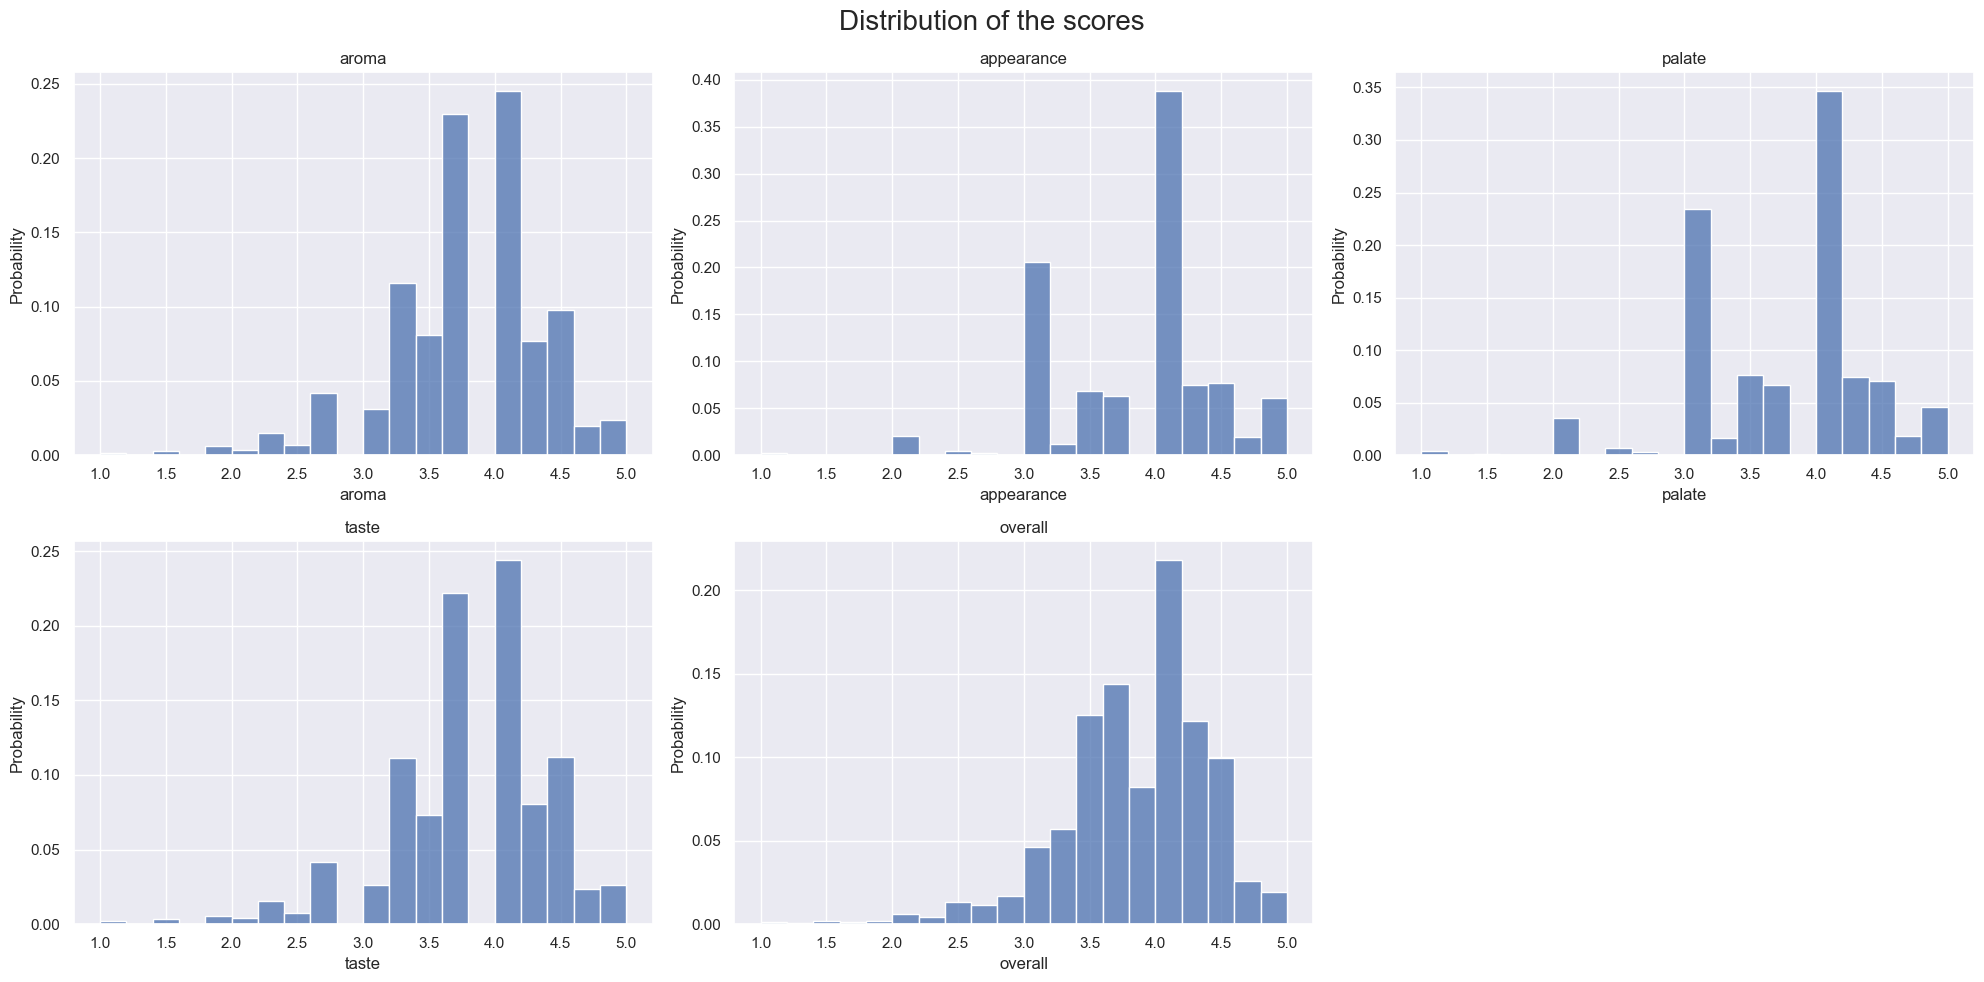

In [24]:
# Compute for each main score the max and min score
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]

# Plot the distribution of the scores
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, score in enumerate(scores_to_compare):
    ax = axs[i // 3][i % 3]
    sns.histplot(us_users_ratings[score], ax=ax, stat="probability", bins=20)
    ax.set_title(score)
    
axs[1][2].set_visible(False)
    
fig.suptitle("Distribution of the scores", fontsize=20)
plt.tight_layout()
plt.show()


In [25]:
# For each score find 5th and 95th percentile
percentile_5 = us_users_ratings[scores_to_compare].quantile(0.05)
percentile_95 = us_users_ratings[scores_to_compare].quantile(0.95)

# Print the diff between 5th and 95th percentile
for score in scores_to_compare:
    print("For {} the diff between 5th and 95th percentile is {}".format(score, percentile_95[score] - percentile_5[score]))

For aroma the diff between 5th and 95th percentile is 1.7777777777777777
For appearance the diff between 5th and 95th percentile is 2.0
For palate the diff between 5th and 95th percentile is 2.0
For taste the diff between 5th and 95th percentile is 1.7777777777777777
For overall the diff between 5th and 95th percentile is 1.6842105263157903


## 2) First analysis : how beers from one country are rated (reviewed)

We first want to look at how beers from a given country are perceived by users. We start from the full dataframe with all the reviews.

### Data cleaning

Let's first look at distribution of number of reviews

In [26]:
columns_compare = ["aroma", "appearance", "palate", "taste", "overall"]

In [27]:
micro_average_ratings = us_users_ratings[columns_compare].mean().sort_values(ascending=False).reset_index()
micro_average_ratings.columns = ["score", "mean"]
display(micro_average_ratings)

# Let's compute statistics for each climate
climate_average_ratings = us_users_ratings.groupby("climate")[columns_compare].mean().sort_values(by="overall", ascending=False).reset_index()
climate_average_ratings.set_index("climate", inplace=True)
macro_average_ratings = climate_average_ratings.mean().sort_values(ascending=False).reset_index()
macro_average_ratings.columns = ["score", "mean"]

display(macro_average_ratings)

,score,mean
0,overall,3.858160
1,appearance,3.809361
2,taste,3.791102
3,aroma,3.768450
4,palate,3.711874


,score,mean
0,overall,3.834160
1,appearance,3.788386
2,taste,3.751408
3,aroma,3.730139
4,palate,3.676703


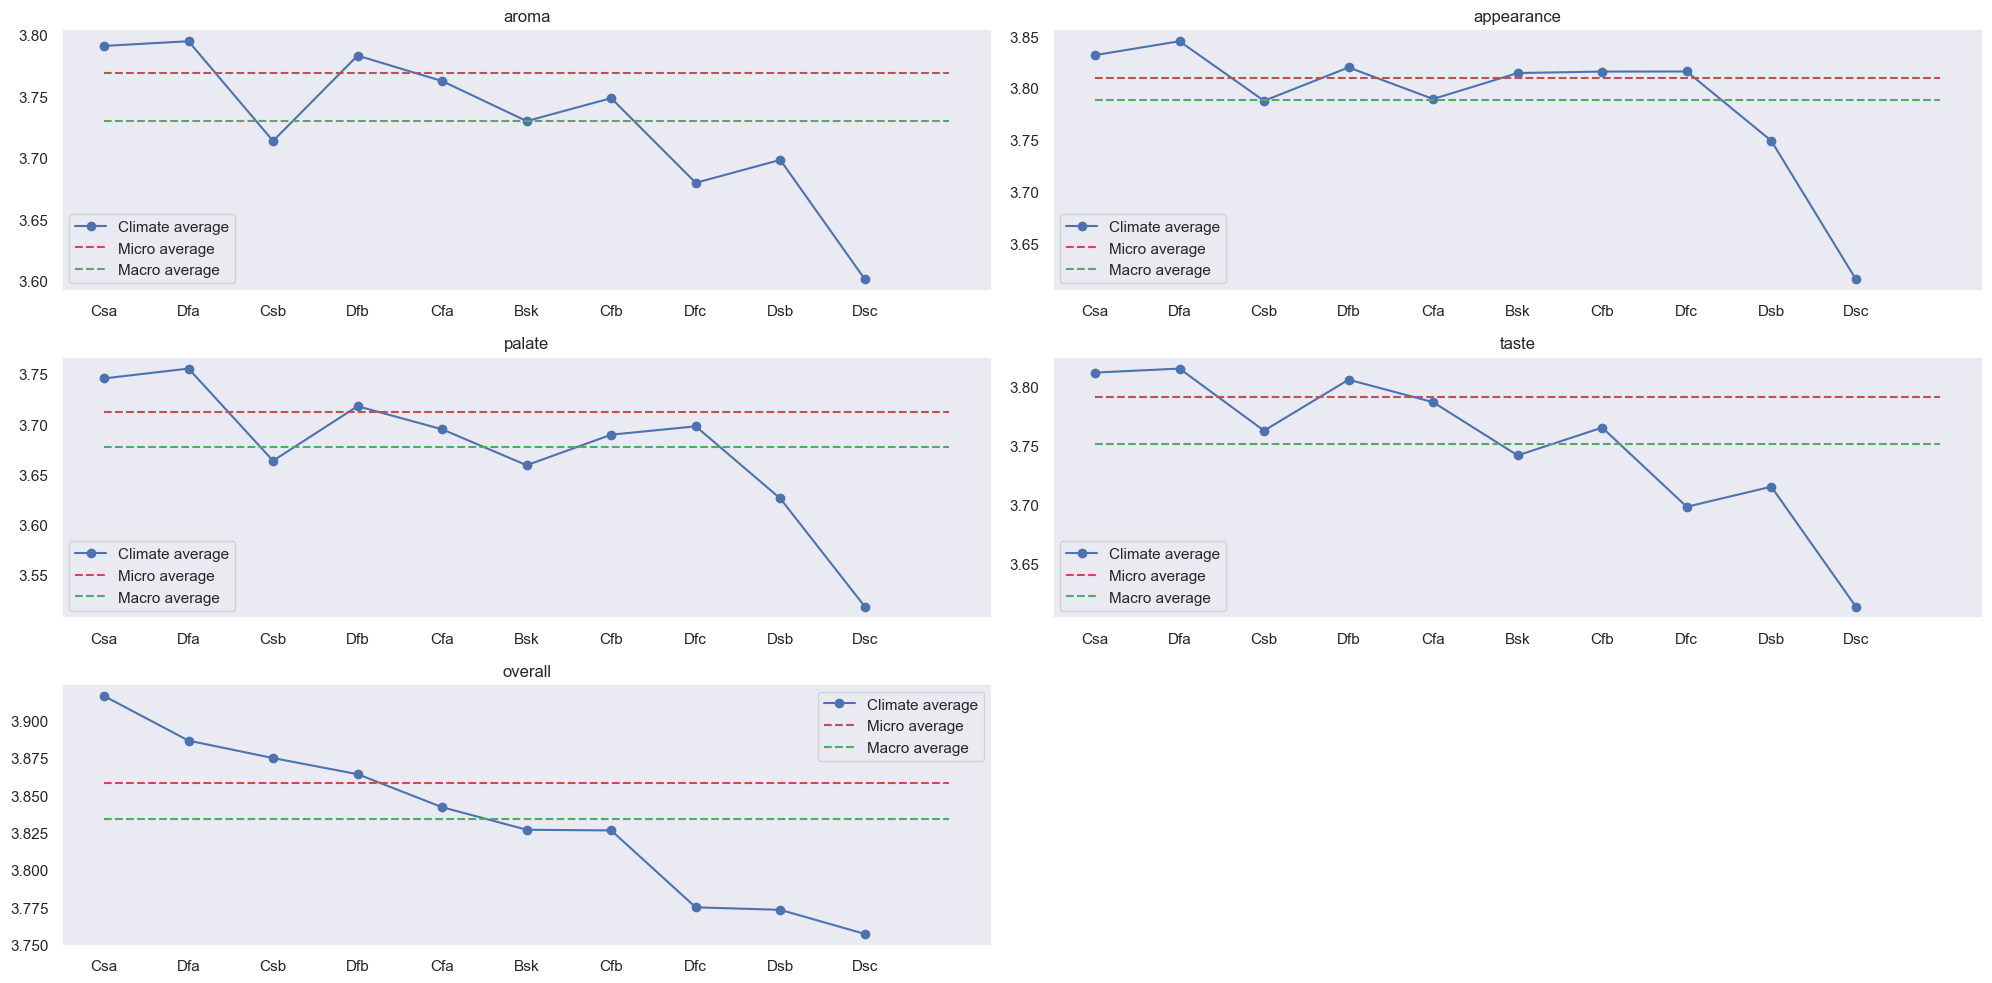

In [30]:
# Plot the different mean as a function of the climate
num_scores = len(columns_compare)

fig, axs = plt.subplots(num_scores//2+1, 2, figsize=(20, 10))

for i in range(num_scores//2):
    axs[i, 0].plot(climate_average_ratings.iloc[:, 2*i], "o-", label="Climate average")
        
    micro_average_value = micro_average_ratings[micro_average_ratings["score"] == columns_compare[2*i]]["mean"].values[0]
    macro_average_value = macro_average_ratings[macro_average_ratings["score"] == columns_compare[2*i]]["mean"].values[0]
    axs[i, 0].plot([0, len(climate_average_ratings)], [micro_average_value, micro_average_value], "r--", label="Micro average")
    axs[i, 0].plot([0, len(climate_average_ratings)], [macro_average_value, macro_average_value], "g--", label="Macro average")
    axs[i, 0].set_title(columns_compare[2*i])
    axs[i, 0].set_xticks(range(len(climate_average_ratings)))
    axs[i, 0].legend()
    axs[i, 0].grid()

    axs[i, 1].plot(climate_average_ratings.iloc[:, 2*i+1], "o-", label="Climate average")
    micro_average_value = micro_average_ratings[micro_average_ratings["score"] == columns_compare[2*i+1]]["mean"].values[0]
    macro_average_value = macro_average_ratings[macro_average_ratings["score"] == columns_compare[2*i+1]]["mean"].values[0]
    axs[i, 1].plot([0, len(climate_average_ratings)], [micro_average_value, micro_average_value], "r--", label="Micro average")
    axs[i, 1].plot([0, len(climate_average_ratings)], [macro_average_value, macro_average_value], "g--", label="Macro average")
    axs[i, 1].set_title(columns_compare[2*i+1])
    axs[i, 1].set_xticks(range(len(climate_average_ratings)))
    axs[i, 1].legend()
    axs[i, 1].grid()

axs[num_scores//2, 0].plot(climate_average_ratings.iloc[:, 2*(num_scores//2)], "o-", label="Climate average")
micro_average_value = micro_average_ratings[micro_average_ratings["score"] == columns_compare[2*(num_scores//2)]]["mean"].values[0]
macro_average_value = macro_average_ratings[macro_average_ratings["score"] == columns_compare[2*(num_scores//2)]]["mean"].values[0]
axs[num_scores//2, 0].plot([0, len(climate_average_ratings)], [micro_average_value, micro_average_value], "r--", label="Micro average")
axs[num_scores//2, 0].plot([0, len(climate_average_ratings)], [macro_average_value, macro_average_value], "g--", label="Macro average")
axs[num_scores//2, 0].set_title(columns_compare[2*(num_scores//2)])
axs[num_scores//2, 0].set_xticks(range(len(climate_average_ratings)))
axs[num_scores//2, 0].legend()
axs[num_scores//2, 0].grid()

axs[num_scores//2, 1].set_visible(False)

plt.tight_layout()
plt.show()

In [31]:
# Let's do sns.barplot for each score per climate
fig, axs = plt.subplots(num_scores//2, 2, figsize=(20, 10))

for i in range(num_scores//2):
    sns.barplot(x="climate", y=columns_compare[2*i], data=us_users_ratings, ax=axs[i, 0])
    axs[i, 0].set_title(columns_compare[2*i])
    axs[i, 0].tick_params(axis="x", rotation=90)
    axs[i, 0].set_ylim(3.5, 4.5)
    
    sns.barplot(x="climate", y=columns_compare[2*i+1], data=us_users_ratings, ax=axs[i, 1])
    axs[i, 1].set_title(columns_compare[2*i+1])
    axs[i, 1].tick_params(axis="x", rotation=90)
    axs[i, 1].set_ylim(3.5, 4.5)
    
plt.tight_layout()
plt.show()

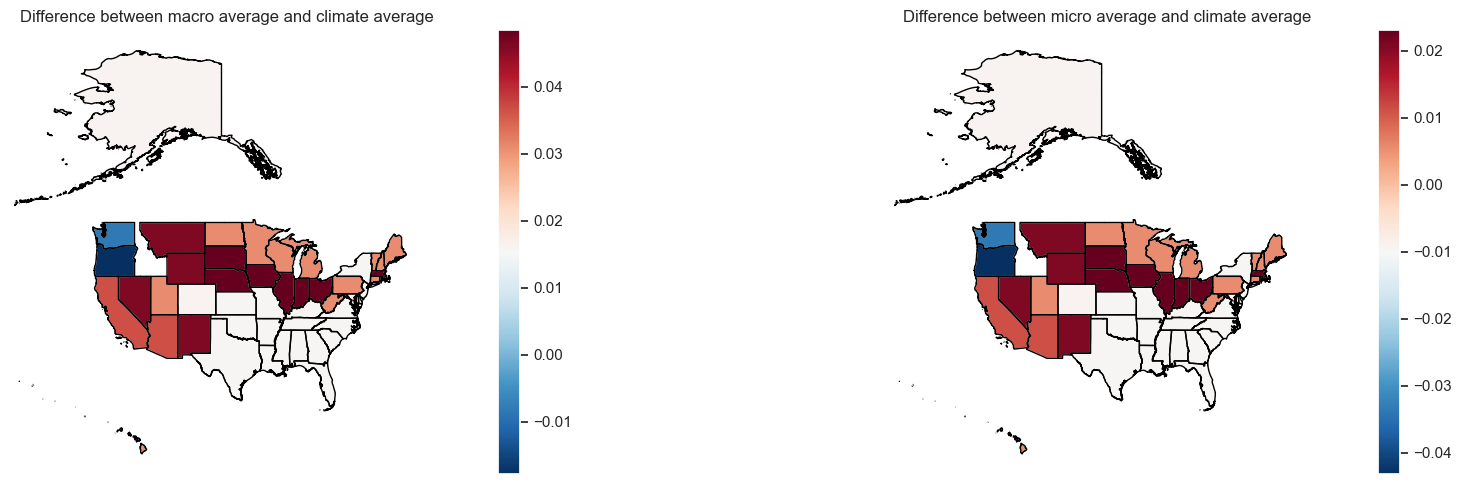

In [95]:
climate_appearance = climate_average_ratings["appearance"].reset_index()

# Drop Dsc climate for testing as it seems like a big outlier
climate_appearance = climate_appearance[climate_appearance["climate"] != "Dsc"]

climate_appearance["diff_macro"] = climate_appearance["appearance"] - macro_average_ratings[macro_average_ratings["index"] == "appearance"][0].values[0]
climate_appearance["diff_micro"] = climate_appearance["appearance"] - micro_average_ratings[micro_average_ratings["index"] == "appearance"][0].values[0]

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

plot_climate_stats(climate_appearance, "diff_macro", "Difference between macro average and climate average", ax=axs[0], symmetrical=True)
plot_climate_stats(climate_appearance, "diff_micro", "Difference between micro average and climate average", ax=axs[1], symmetrical=True)

plt.tight_layout()
plt.show()

Let's go in more in-depth analysis of the climate distribution

In [21]:
# First we can print the number of reviews per climate
print("Number of reviews per climate:")
display(us_users_ratings["climate"].value_counts())

Number of reviews per climate:


climate
Cfa    85617
Dfb    50644
Dfa    44947
Csa    22066
Dsb     8202
Dfc     7704
Csb     4708
Bsk     2150
Cfb     1148
Dsc     1008
Name: count, dtype: int64

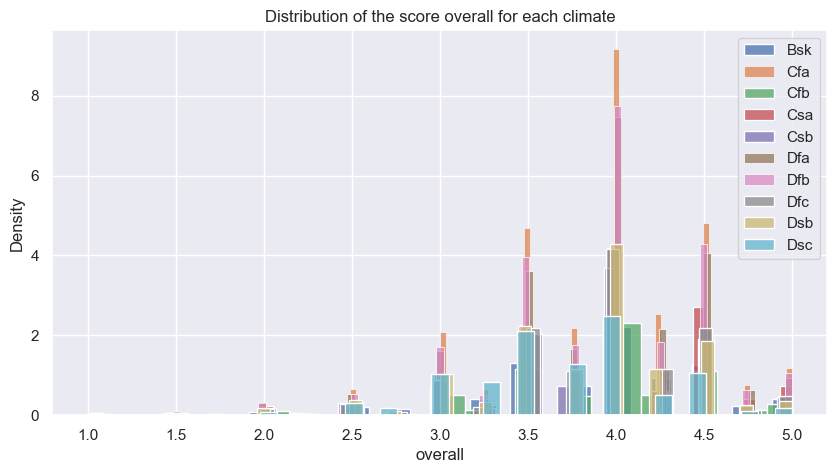

In [31]:
# For one chosen score, plot the distribution of the score for each climate
score = "overall"

# Get the data
data_to_plot = us_users_ratings[["climate", score]].copy()
data_to_plot = data_to_plot.groupby("climate")[score].apply(list).reset_index()

# Plot the data
box_plot = False
if box_plot:
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.boxplot(data_to_plot[score])
    ax.set_xticklabels(data_to_plot["climate"])
    ax.set_ylabel(score)
    ax.set_title("Distribution of the score " + score + " for each climate")
else:
    # Use superimposed histograms
    fig, ax = plt.subplots(figsize=(10, 5))
    for i in range(len(data_to_plot)):
        sns.histplot(data_to_plot[score][i], ax=ax, label=data_to_plot["climate"][i], stat="density")
    ax.set_xlabel(score)
    ax.set_ylabel("Density")
    ax.set_title("Distribution of the score " + score + " for each climate")
    ax.legend()
    
    
plt.show()

In [32]:
for score in scores_to_compare:
    # do anova test to compare mean overall rating for first beer of the top 5 and each climate zone:
    res = stats.f_oneway(
        *[
            us_users_ratings[us_users_ratings.climate == zone][score]
            for zone in us_users_ratings.climate.unique()
        ],
        axis=0
    )
    print(score, res[1])

aroma 1.5447681797415555e-57
appearance 1.0068470584746253e-72
palate 6.433686680395055e-54
taste 1.7844392691434385e-42
overall 7.898058855631734e-51


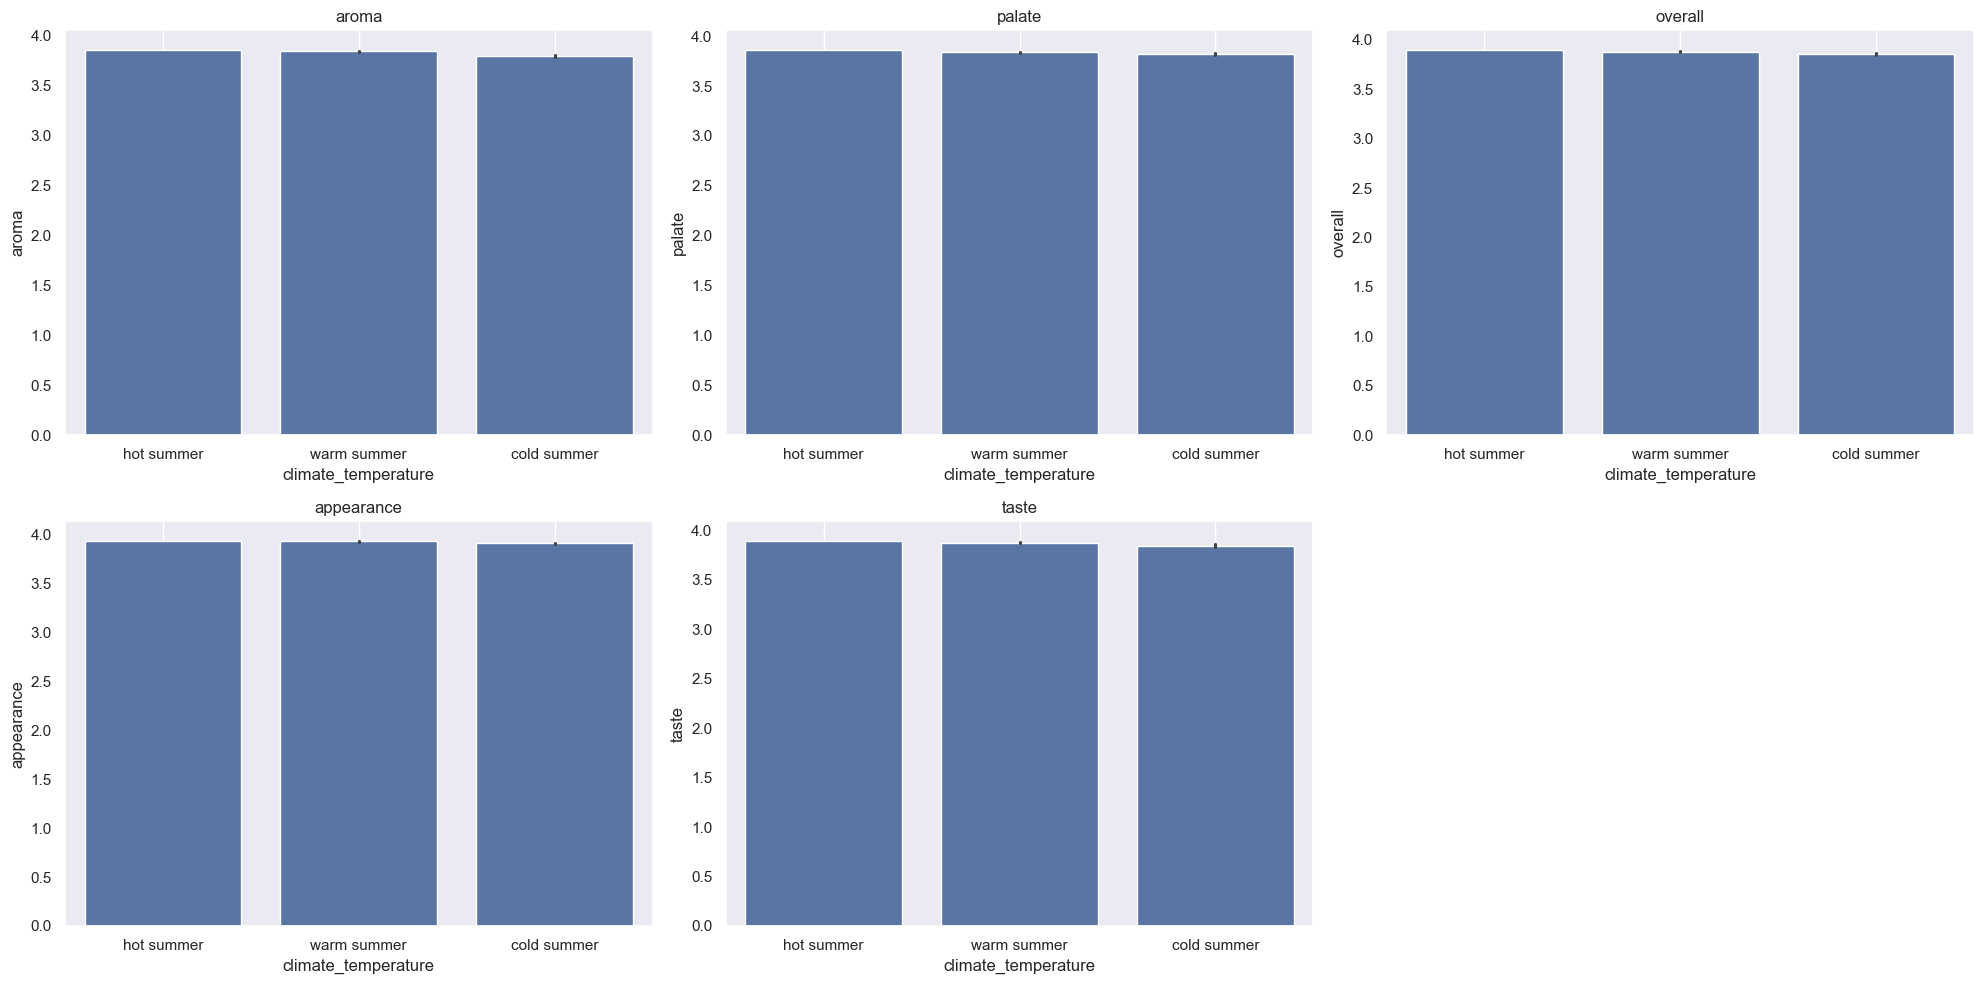

In [44]:
# Plot the average overall score for each climate
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, score in enumerate(scores_to_compare):
    sns.barplot(x=us_users_ratings["climate_temperature"], y=us_users_ratings[score], ax=ax[i%2, i//2])
    ax[i%2, i//2].set_title(score)
    ax[i%2, i//2].grid()
    
ax[1, 2].axis("off")    
plt.tight_layout()
plt.show()


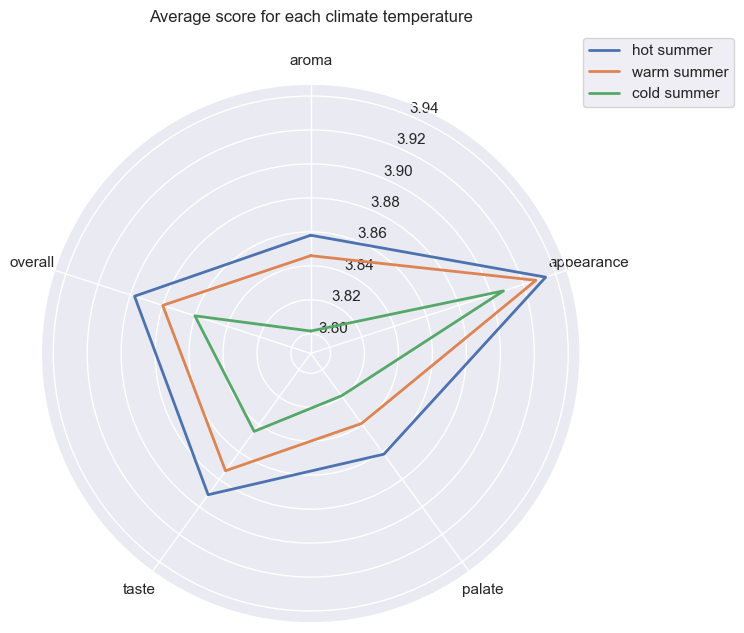

In [96]:
# Now let's analyze but using the climate_temperature column
climate_temperature_dfs = {}
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]
averages_scores = {}

for climate_t in climate_classifications["heat_level"].unique():
    climate_temperature_dfs[climate_t] = us_users_ratings[us_users_ratings["climate_temperature"] == climate_t]
    
    for score in scores_to_compare:
        averages_scores[(climate_t, score)] = climate_temperature_dfs[climate_t][score].mean()

# Use a pandas polar plot to plot the average score for each climate
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

# Set the angle of the ticks
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set the ticks
ticks = np.linspace(0, 2 * np.pi, len(scores_to_compare), endpoint=False)
ticks = np.append(ticks, ticks[0])

ax.set_xticks(ticks[:-1])
ax.set_xticklabels([score for score in scores_to_compare])

for climate_t in climate_classifications["heat_level"].unique():
    # Get the average score for each climate
    average_score = [averages_scores[(climate_t, score)] for score in scores_to_compare]
    average_score.append(average_score[0])
    
    # Plot the average score for each climate
    ax.plot(ticks, average_score, label=climate_t, linewidth=2)

# Get the minimum and maximum average score
min_average_score = min([mean for mean in averages_scores.values()])
max_average_score = max([mean for mean in averages_scores.values()])
diff_average_score = max_average_score - min_average_score
ax.set_ylim(min_average_score - 0.1 * diff_average_score, max_average_score + 0.1 * diff_average_score)

# Set the title
ax.set_title("Average score for each climate temperature", y=1.1)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.show()

In [45]:
for score in scores_to_compare:
    # do anova test to compare mean overall rating for first beer of the top 5 and each climate zone:
    res = stats.f_oneway(
        *[
            us_users_ratings[us_users_ratings.climate_temperature == zone][score]
            for zone in us_users_ratings.climate_temperature.unique()
        ],
        axis=0
    )
    print(score, res[1])

aroma 7.30517524946938e-22
appearance 1.827993680667721e-06
palate 2.774900832065505e-22
taste 5.80878704512254e-17
overall 2.3197516001391447e-14


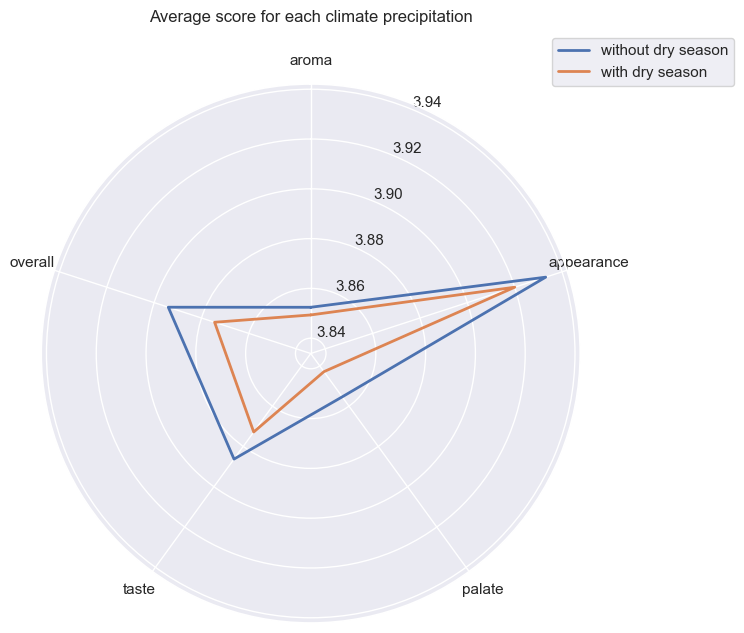

In [113]:
# Now let's analyze but using the climate_temperature column
climate_precipitation_dfs = {}
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]
averages_scores = {}

for climate_prec in climate_classifications["seasonal_precipitation"].unique():
    climate_precipitation_dfs[climate_prec] = us_users_ratings[us_users_ratings["climate_precipitation"] == climate_prec]
    
    for score in scores_to_compare:
        averages_scores[(climate_prec, score)] = climate_precipitation_dfs[climate_prec][score].mean()

# Use a pandas polar plot to plot the average score for each climate
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

# Set the angle of the ticks
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set the ticks
ticks = np.linspace(0, 2 * np.pi, len(scores_to_compare), endpoint=False)
ticks = np.append(ticks, ticks[0])

ax.set_xticks(ticks[:-1])
ax.set_xticklabels([score for score in scores_to_compare])

for climate_t in climate_classifications["seasonal_precipitation"].unique():
    # Get the average score for each climate
    average_score = [averages_scores[(climate_t, score)] for score in scores_to_compare]
    average_score.append(average_score[0])
    
    # Plot the average score for each climate
    ax.plot(ticks, average_score, label=climate_t, linewidth=2)

# Get the minimum and maximum average score
min_average_score = min([mean for mean in averages_scores.values()])
max_average_score = max([mean for mean in averages_scores.values()])
diff_average_score = max_average_score - min_average_score
ax.set_ylim(min_average_score - 0.1 * diff_average_score, max_average_score + 0.1 * diff_average_score)

# Set the title
ax.set_title("Average score for each climate precipitation", y=1.1)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.show()

In [114]:
for score in scores_to_compare:
    res = stats.f_oneway(
        *[
            us_users_ratings[us_users_ratings.climate_precipitation == zone][score]
            for zone in us_users_ratings.climate_precipitation.unique()
        ],
        axis=0
    )
    
    print(score, res[1])

aroma 0.36339612657538256
appearance 1.782729251078708e-05
palate 0.00021450512380483933
taste 0.00020318962580199767
overall 2.49709776971272e-08


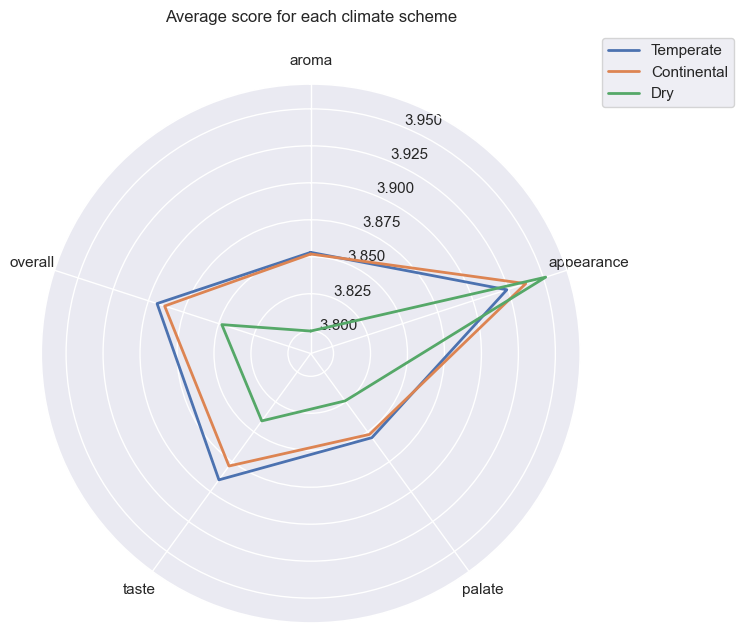

In [115]:
# Now let's analyze but using the climate_scheme column
climate_scheme_dfs = {}
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]
averages_scores = {}

for climate_s in climate_classifications["scheme"].unique():
    climate_scheme_dfs[climate_s] = us_users_ratings[us_users_ratings["climate_scheme"] == climate_s]
    
    for score in scores_to_compare:
        averages_scores[(climate_s, score)] = climate_scheme_dfs[climate_s][score].mean()
        
# Use a pandas polar plot to plot the average score for each climate
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

# Set the angle of the ticks
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set the ticks
ticks = np.linspace(0, 2 * np.pi, len(scores_to_compare), endpoint=False)
ticks = np.append(ticks, ticks[0])

ax.set_xticks(ticks[:-1])
ax.set_xticklabels([score for score in scores_to_compare])

for climate_t in climate_classifications["scheme"].unique():
    # Get the average score for each climate
    average_score = [averages_scores[(climate_t, score)] for score in scores_to_compare]
    average_score.append(average_score[0])
    
    # Plot the average score for each climate
    ax.plot(ticks, average_score, label=climate_t, linewidth=2)

# Get the minimum and maximum average score
min_average_score = min([mean for mean in averages_scores.values()])
max_average_score = max([mean for mean in averages_scores.values()])
diff_average_score = max_average_score - min_average_score
ax.set_ylim(min_average_score - 0.1 * diff_average_score, max_average_score + 0.1 * diff_average_score)

# Set the title
ax.set_title("Average score for each climate scheme", y=1.1)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.show()


In [116]:
for score in scores_to_compare:
    res = stats.f_oneway(
        *[
            us_users_ratings[us_users_ratings.climate_scheme == zone][score]
            for zone in us_users_ratings.climate_scheme.unique()
        ],
        axis=0
    )
    
    print(score, res[1])

aroma 0.0002779856667845251
appearance 6.06619127405772e-09
palate 0.04400723027013623
taste 9.041315598130121e-07
overall 0.0007361974833128883
